In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# 1. Load data
start_df = pd.read_csv('Data.csv')
start_df['Dates'] = pd.to_datetime(start_df['Dates'])
start_df = start_df.sort_values('Dates').set_index('Dates')

# 2. Clean the dataset and reject the negative price. It's the pragmatic thing to do at this stage.
start_df = start_df[start_df > 0]

start_df

In [ ]:
df_log_returns = np.log(start_df / start_df.shift(1)).dropna()

In [ ]:
corr_matrix = df_log_returns.rolling(32).corr().dropna()

In [ ]:
# Rolling correlation (multi-index)
rolling_corr = df_log_returns.rolling(32).corr()

# Ricomponi le matrici in un cubo (time, asset1, asset2)
assets = df_log_returns.columns
dates = df_log_returns.index[31:]  # le prime 31 sono NaN
n_assets = len(assets)
n_dates = len(dates)

# Pivot per ottenere (n_dates, n_assets, n_assets)
corr_cube = np.empty((n_dates, n_assets, n_assets))

for i, date in enumerate(dates):
    corr_matrix = rolling_corr.loc[date]
    corr_cube[i] = corr_matrix.values

# Media delle matrici nel tempo
avg_corr_matrix = np.mean(corr_cube, axis=0)

mask = np.triu(np.ones_like(avg_corr_matrix, dtype=bool))
palette = sns.diverging_palette(240, 10, n=9, s=100, l=50, as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(
    avg_corr_matrix,
    mask=mask,
    cmap=palette,        # diverging palette
    vmin=-1, vmax=1,        # ensure full correlation range
    center=0,
    annot=True,             # show numbers
    fmt=".2f",              # 2 decimal places
    annot_kws={"size": 8},  # control number size
    square=True,            # make cells square
    linewidths=0.5,         # white lines between cells
    xticklabels=assets,     # <— here
    yticklabels=assets,
    cbar_kws={"shrink": 0.75, "label": "Correlation"})
plt.title("Average Rolling 32-Day Correlation Matrix")
# Tweak the tick labels
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# rolling correlation su 32 giorni
rolling_corrs = {}
window = 32

for a1, a2 in combinations(df_log_returns.columns, 2):
    pair_name = f"{a1}-{a2}"
    corr_series = df_log_returns[a1].rolling(window).corr(df_log_returns[a2])
    rolling_corrs[pair_name] = corr_series

# metti tutto in un DataFrame
rolling_corr_df = pd.DataFrame(rolling_corrs)

# calcola media e std delle correlazioni rolling negli ultimi N giorni (es. ultimi 100)
summary = pd.DataFrame({
    'mean_corr': rolling_corr_df.tail(100).mean(),
    'std_corr': rolling_corr_df.tail(100).std()
})

# ordina per correlazione alta
summary = summary.sort_values(by=['mean_corr'], ascending=False)

print(summary.head(10))  # Le 10 coppie migliori

In [91]:
trades = [summary.index[1].split("-"),summary.index[2].split("-"),summary.index[3].split("-"),summary.index[4].split("-")]

In [95]:
def compute_spread(df_prices, asset1, asset2):
    log_price_1 = np.log(df_prices[asset1])
    log_price_2 = np.log(df_prices[asset2])
    spread = log_price_1 - log_price_2
    return spread

spreads = {}
for a1, a2 in trades:
    spread = compute_spread(start_df, a1, a2)
    pair_name = f"{a1}-{a2}"
    spreads[pair_name] = spread

df_spreads = pd.DataFrame(spreads)

def compute_zscore(spread, window=32):
    mean = spread.rolling(window).mean()
    std = spread.rolling(window).std()
    zscore = (spread - mean) / std
    return zscore
z_scores = {}

for pair_name, spread_series in spreads.items():
    z = compute_zscore(spread_series, window=32)
    z_scores[pair_name] = z

df_zscores = pd.DataFrame(z_scores)
df_zscores = df_zscores.dropna()


In [102]:
def run_strategy_on_pair(spread_series, z_series,
                         z_entry=2.0, z_exit=0.5, z_stop=3.0, max_holding=32):
    trades = []
    position = None  # None, 'long', 'short'
    entry_day = None
    entry_spread = None
    entry_z = None

    for day in range(len(spread_series)):
        z = z_series.iloc[day]
        date = z_series.index[day]
        spread = spread_series.iloc[day]

        if pd.isna(z):
            continue

        # ENTRY
        if position is None:
            if z > z_entry:
                position = 'short'  # short asset1, long asset2
                entry_day = date
                entry_spread = spread
                entry_z = z
            elif z < -z_entry:
                position = 'long'  # long asset1, short asset2
                entry_day = date
                entry_spread = spread
                entry_z = z

        # EXIT
        elif position is not None:
            days_open = (date - entry_day).days

            # take profit
            if abs(z) < z_exit:
                reason = 'take_profit'
            # stop loss
            elif abs(z) > z_stop:
                reason = 'stop_loss'
            # time limit
            elif (date - entry_day).days >= (max_holding - 1):
                reason = 'time_limit'
            else:
                continue  # keep position

            # compute PnL (differenza spread, direzione coerente)
            pnl = spread - entry_spread if position == 'long' else entry_spread - spread

            trades.append({
                'entry_date': entry_day,
                'exit_date': date,
                'position': position,
                'entry_z': entry_z,
                'exit_z': z,
                'entry_spread': entry_spread,
                'exit_spread': spread,
                'pnl': pnl,
                'duration': days_open,
                'reason': reason
            })

            # reset position
            position = None
            entry_day = None
            entry_spread = None
            entry_z = None

    return pd.DataFrame(trades)


In [103]:
results = []

# Assumiamo che le colonne siano le stesse in df_spreads e df_zscores
common_cols = df_spreads.columns.intersection(df_zscores.columns)

for col in common_cols:
    # Trova le date comuni per questa coppia
    common_dates = df_spreads.index.intersection(df_zscores.index)

    # Estrai le serie allineate
    spread_series = df_spreads.loc[common_dates, col]
    zscore_series = df_zscores.loc[common_dates, col]

    # Esegui la strategia
    trades = run_strategy_on_pair(spread_series, zscore_series)
    trades['pair'] = col  # aggiungi nome coppia ai risultati

    # Salva i risultati
    results.append(trades)

# Unisci tutti i trade in un unico DataFrame
all_trades = pd.concat(results, ignore_index=True)

# Mostra i primi risultati
print(all_trades.head())


  entry_date  exit_date position   entry_z    exit_z  entry_spread  \
0 2010-07-01 2010-07-13     long -2.028280 -0.492335     -0.169316   
1 2010-08-06 2010-09-03     long -2.509021 -0.371107     -0.174161   
2 2010-11-16 2010-12-17    short  2.286342  1.278000     -0.163336   
3 2011-02-01 2011-02-17    short  2.050726  0.046106     -0.129764   
4 2011-04-08 2011-04-15    short  2.171458  0.461158     -0.115510   

   exit_spread       pnl  duration       reason                    pair  
0    -0.164602  0.004714        12  take_profit  Germany_2y-Germany_10y  
1    -0.184870 -0.010709        28  take_profit  Germany_2y-Germany_10y  
2    -0.135716 -0.027620        31   time_limit  Germany_2y-Germany_10y  
3    -0.133866  0.004102        16  take_profit  Germany_2y-Germany_10y  
4    -0.123632  0.008122         7  take_profit  Germany_2y-Germany_10y  


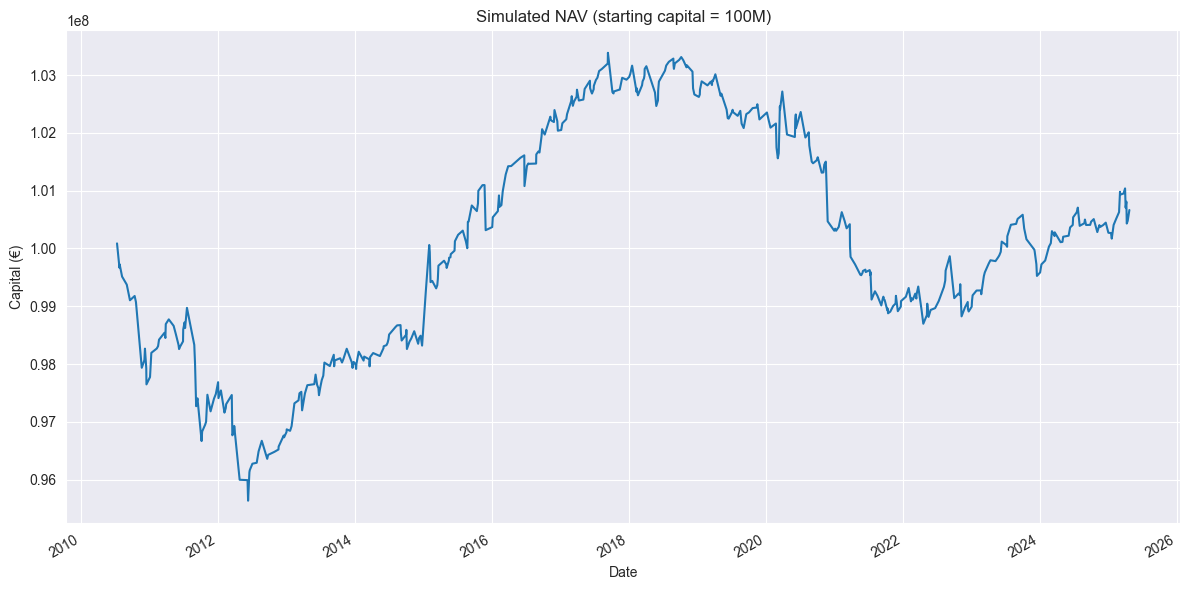

📈 Rendimento totale: 577,739.70 € (0.58%)
📉 Max drawdown: -4,689,312.77 €
📊 Sharpe ratio (daily, annualized): 0.03
pair
Germany_Equity-Spain_Equity    528617.404640
USDJPY-CHFJPY                  294323.305436
US_2y-US_10y                     6558.284893
Germany_2y-Germany_10y        -164348.886587
Name: pnl_euro, dtype: float64


In [107]:
notional = 10_000_000  # 10 milioni per trade
all_trades['pnl_euro'] = all_trades['pnl'] * notional


# Ordina i trade per data di uscita
all_trades = all_trades.sort_values('exit_date')

# Crea DataFrame con date e pnl
pnl_series = all_trades.groupby('exit_date')['pnl_euro'].sum().cumsum()

# Capitale iniziale
starting_capital = 100_000_000
nav_series = starting_capital + pnl_series


plt.figure(figsize=(12, 6))
nav_series.plot()
plt.title("Simulated NAV (starting capital = 100M)")
plt.ylabel("Capital (€)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

# Ricostruisci un DateTimeIndex completo
all_dates = pd.date_range(start=nav_series.index.min(), end=nav_series.index.max())

# Reindicizza e fill-forward
nav_full = nav_series.reindex(all_dates).ffill().fillna(starting_capital)

total_return = nav_full.iloc[-1] - nav_full.iloc[0]
total_return_pct = (nav_full.iloc[-1] / nav_full.iloc[0] - 1) * 100

daily_returns = nav_full.pct_change().dropna()
sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

rolling_max = nav_full.cummax()
drawdown = nav_full - rolling_max
max_drawdown = drawdown.min()

print(f"📈 Rendimento totale: {total_return:,.2f} € ({total_return_pct:.2f}%)")
print(f"📉 Max drawdown: {max_drawdown:,.2f} €")
print(f"📊 Sharpe ratio (daily, annualized): {sharpe:.2f}")

by_pair = all_trades.groupby('pair')['pnl_euro'].sum().sort_values(ascending=False)
print(by_pair)
